In [1]:
import json
import pandas as pd
import numpy as np
import random

In [2]:
# Basics
import utils.basics.converter as convert
import utils.basics.presenter as show

import utils.simple.schedule_solver as simple_ssv

In [3]:
import utils.checker as check

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


## I) Mittlere Zwischenankunftszeit t_a

### 1. Vektor der Bearbeitungszeiten auf der Engpassmaschine

#### a) Bestimmung der Engpassmaschine (7.12)

$$
m_{\text{max}} = \arg\max_{m \in M} T_m
$$

In [9]:
def get_engpassmaschine(df, debug=False):
    """
    Ermittelt die Maschine mit der höchsten Gesamtbearbeitungszeit (Bottleneck) aus einem DataFrame.

    Parameter:
    - df: DataFrame mit Spalten ['Job','Machine','Processing Time']
          Machine kann entweder als int oder als String 'M{int}' vorliegen.
    - debug: Wenn True, wird die vollständige Auswertung der Maschinenbelastung ausgegeben.

    Rückgabe:
    - Index der Engpassmaschine (int)
    """
    d = df.copy()
    # Falls Machine als 'M0','M1',... vorliegt, entfernen wir das 'M'
    if d['Machine'].dtype == object:
        d['Machine'] = d['Machine'].str.lstrip('M').astype(int)
    # Gesamtbearbeitungszeit pro Maschine
    usage = d.groupby('Machine')['Processing Time'].sum().to_dict()
    if debug:
        print("Maschinenbelastung (Gesamtverarbeitungszeit):")
        for m, total in sorted(usage.items()):
            print(f"  M{m}: {total}")
    # Maschine mit maximaler Gesamtzeit
    return max(usage, key=usage.get)

get_engpassmaschine(df_instance, debug = True)

Maschinenbelastung (Gesamtverarbeitungszeit):
  M0: 493
  M1: 548
  M2: 556
  M3: 631
  M4: 534
  M5: 416
  M6: 491
  M7: 499
  M8: 531
  M9: 410


3

#### b) Vektor der Bearbeitungszeiten auf der Engpassmaschine erstellen

In [11]:
def get_vec_t_b_mmax(df):
    """
    Ermittelt für jeden Job die Bearbeitungszeit auf der Engpassmaschine.

    Parameter:
    - df: DataFrame mit Spalten ['Job','Machine','Processing Time']

    Rückgabe:
    - Liste der Bearbeitungszeiten auf der Engpassmaschine, in der Reihenfolge
      der ersten Vorkommen der Jobs in df['Job'].
    """
    # 1) Kopie und Machine-Spalte in int umwandeln, falls nötig
    d = df.copy()
    if d['Machine'].dtype == object:
        d['Machine'] = d['Machine'].str.lstrip('M').astype(int)

    # 2) Engpassmaschine bestimmen
    eng = get_engpassmaschine(d)

    # 3) Job-Reihenfolge festlegen
    job_order = d['Job'].unique().tolist()

    # 4) Zeiten auf Engpassmaschine extrahieren
    proc_on_eng = d[d['Machine'] == eng].set_index('Job')['Processing Time'].to_dict()

    # 5) Vektor aufbauen (0, wenn ein Job die Maschine nicht nutzt)
    vec = [proc_on_eng.get(job, 0) for job in job_order]
    return vec
    
vec_t_b_mmax = get_vec_t_b_mmax(df_instance)
vec_t_b_mmax

[36, 69, 39, 98, 26, 95, 61, 79, 76, 52]

### 2. Job-Wahrscheinlichkeiten

In [13]:
# Anzahl unterschiedlicher Jobs
n_jobs = df_instance['Job'].nunique()

p = [1.0 / n_jobs] * n_jobs
p

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

### 3. Berechne die mittlere Zwischenankunftszeit t_a nach Formel (7.16)

$$
t_a = \frac{\vec{p}^T \cdot \vec{t}_{b, m_{\text{max}}}}{u_{b, m_{\text{max}}}}
$$

- $t_a$: mittlere Zwischenankunftszeit  
- $\vec{p}$: Vektor der Wahrscheinlichkeiten der Arbeitspläne (bzw. Jobs)  
- $\vec{t}_{b, m_{\text{max}}}$: Vektor der Bearbeitungszeiten auf der Engpassmaschine  
- $u_{b, m_{\text{max}}}$: gewünschte Auslastung der Engpassmaschine

In [16]:
def calculate_mean_interarrival_time(df, u_b_mmax: float = 0.9) -> float:
    """
    Berechnet die mittlere Interarrival-Zeit t_a für ein DataFrame,
    sodass die Engpassmaschine mit Auslastung u_b_mmax (< 1.0) betrieben wird.

    Parameter:
    - df: DataFrame mit Spalten ['Job','Machine','Processing Time']
    - u_b_mmax: Ziel-Auslastung der Engpassmaschine (z.B. 0.9)

    Rückgabe:
    - t_a: mittlere Interarrival-Zeit, gerundet auf 2 Dezimalstellen
    """
    # Anzahl der unterschiedlichen Jobs
    n_jobs = df['Job'].nunique()
    # Gleichverteilung über die Jobs
    p = [1.0 / n_jobs] * n_jobs

    # Vektor der Bearbeitungszeiten auf der Engpassmaschine
    vec_t_b_mmax = get_vec_t_b_mmax(df)

    # Berechnung der mittleren Interarrival-Zeit
    t_a = sum(p[i] * vec_t_b_mmax[i] for i in range(n_jobs)) / u_b_mmax
    return round(t_a, 2)


In [17]:
t_a =  calculate_mean_interarrival_time(df_instance, u_b_mmax = 0.9)
t_a

70.11

## II) Ankunftszeiten

#### Generierung exponentiell verteilte Zwischenankunftszeiten mit Mittelwert t_a 
#### mit eine zufällige Job-Reihenfolge

In [20]:
import numpy as np
import pandas as pd

def generate_arrival_dataframe(df_jssp: pd.DataFrame,
                               t_a: float,
                               perm_seed: int = 12,
                               exp_seed: int = 123) -> pd.DataFrame:
    """
    Erzeugt ein DataFrame mit zufälligen Ankunftszeiten für jeden Job.

    Parameter:
    - df_jssp: DataFrame mit mindestens der Spalte 'Job'.
    - t_a: mittlere Interarrival-Zeit (Skala für Exponentialverteilung).
    - perm_seed: Zufallssamen für die Permutation der Jobs.
    - exp_seed: Zufallssamen für die Exponentialverteilung.

    Rückgabe:
    - df_arrivals: DataFrame mit Spalten ['Job','Arrival'], sortiert nach 'Arrival'.
    """
    # 1) Eindeutige Job-Namen und Anzahl
    job_names = df_jssp['Job'].unique().tolist()
    n_jobs = len(job_names)

    # 2) Permutation der Job-Reihenfolge
    np.random.seed(perm_seed)
    shuffled_jobs = list(np.random.permutation(job_names))

    # 3) Exponentiell verteilte Interarrival-Zeiten
    np.random.seed(exp_seed)
    interarrival_times = np.random.exponential(scale=t_a, size=n_jobs)

    # 4) Absolute Ankunftszeiten (kumuliert und gerundet)
    arrival_times = np.cumsum(interarrival_times)
    arrival_times = np.round(arrival_times, 2)

    # 5) Kombination und Sortierung
    df_arrivals = pd.DataFrame({
        'Job': shuffled_jobs,
        'Arrival': arrival_times
    }).sort_values('Arrival').reset_index(drop=True)

    return df_arrivals


df_arrivals = generate_arrival_dataframe(df_instance, t_a)
df_arrivals

,Job,Arrival
0,job 5,83.59
1,job 8,107.22
2,job 7,125.26
3,job 0,181.45
4,job 4,270.56
5,job 9,309.13
6,job 3,586.13
7,job 2,667.09
8,job 1,713.06
9,job 6,747.96


## III) Scheduling

### a) First Come First Serve

In [23]:
df_fcfs = simple_ssv.schedule_fcfs_with_arrivals(df_instance, df_arrivals)
df_fcfs

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,job 5,0,83.59,M2,83.59,84,167.59
2,job 5,1,83.59,M1,167.59,2,169.59
4,job 5,2,83.59,M5,169.59,52,221.59
8,job 5,3,83.59,M3,221.59,95,316.59
12,job 5,4,83.59,M8,316.59,48,364.59
...,...,...,...,...,...,...,...
87,job 6,5,747.96,M5,1183.22,21,1204.22
89,job 6,6,747.96,M9,1204.22,32,1236.22
90,job 6,7,747.96,M8,1236.22,89,1325.22
96,job 6,8,747.96,M7,1351.22,30,1381.22


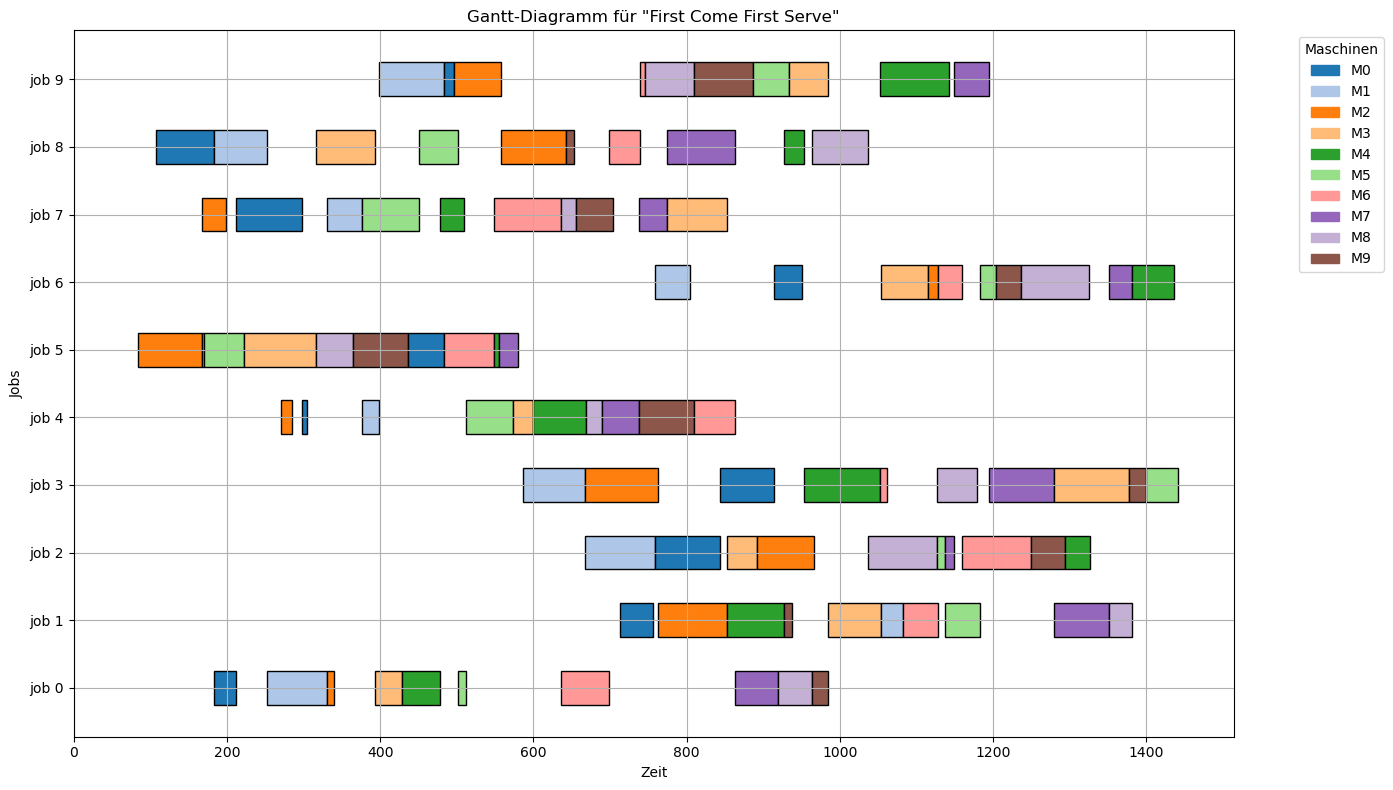

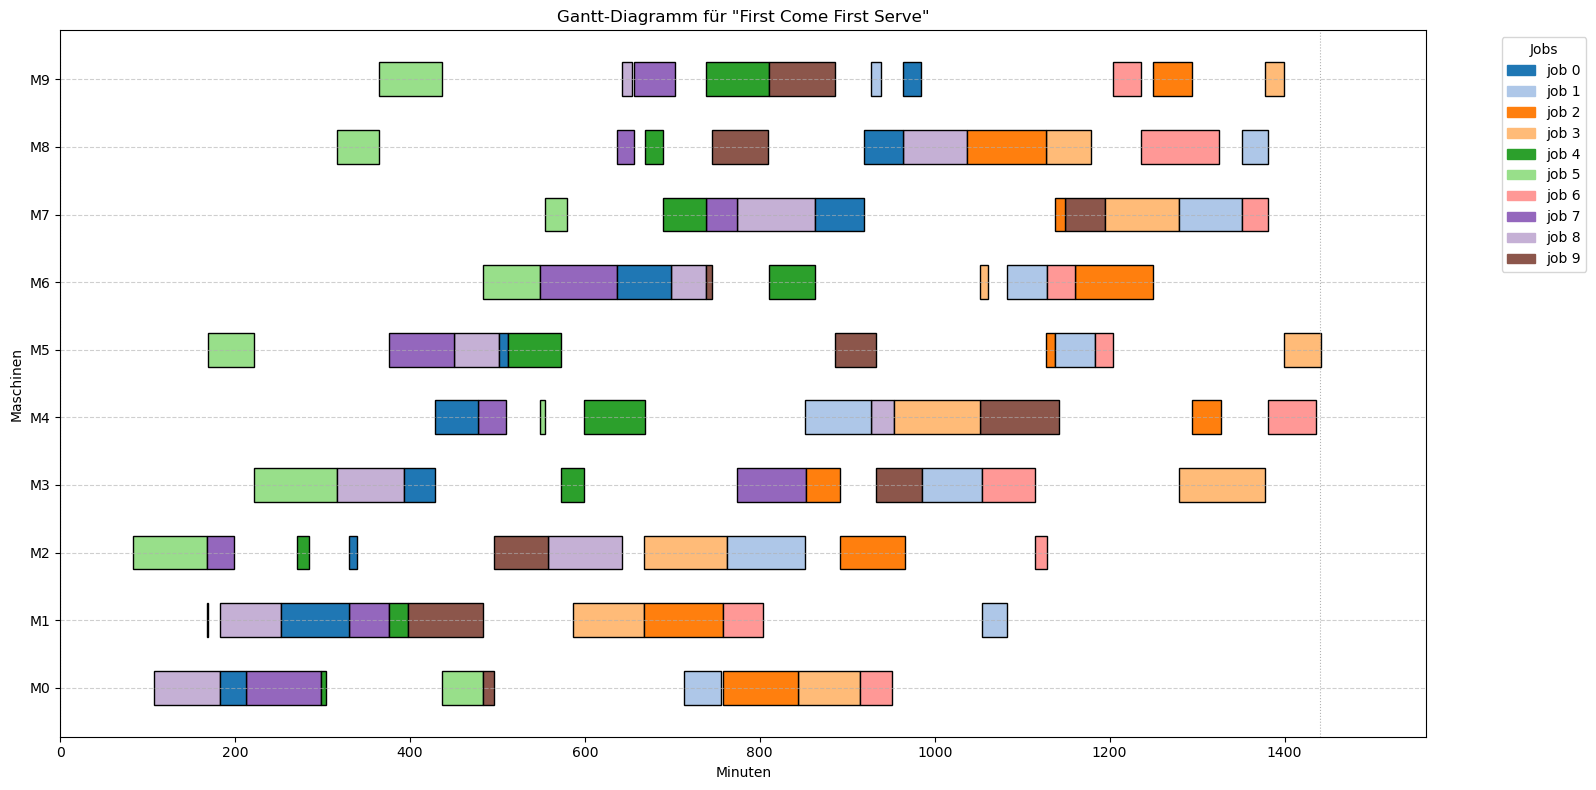

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [24]:
category = "First Come First Serve"

show.plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_fcfs)

### b) HiGHS

In [26]:
df_schedule_highs, makespan = simple_ssv.solve_jssp_global_makespan(df_instance, df_arrivals, solver_time_limit=360)
df_schedule_highs.sort_values(by="Start").reset_index(drop=True)
df_schedule_highs

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 5,0,83.59,M2,83.59,84,84.00,167.59
1,job 5,1,83.59,M1,167.59,2,86.00,169.59
2,job 5,2,83.59,M5,169.59,52,138.00,221.59
3,job 5,3,83.59,M3,221.59,95,233.00,316.59
4,job 5,4,83.59,M8,316.59,48,281.00,364.59
...,...,...,...,...,...,...,...,...
95,job 6,5,747.96,M5,1119.37,21,392.41,1140.37
96,job 6,6,747.96,M9,1140.37,32,424.41,1172.37
97,job 6,7,747.96,M8,1172.37,89,513.41,1261.37
98,job 6,8,747.96,M7,1261.37,30,543.41,1291.37


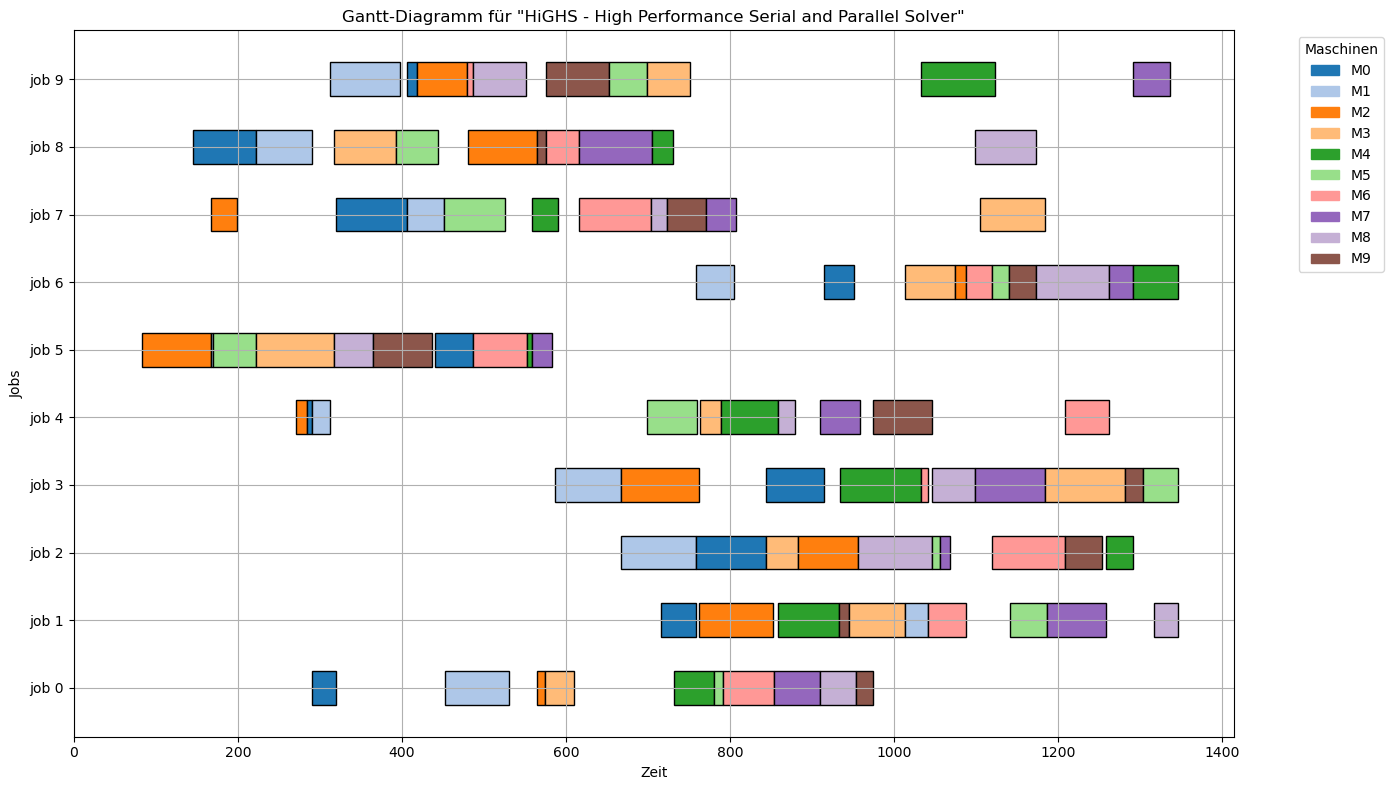

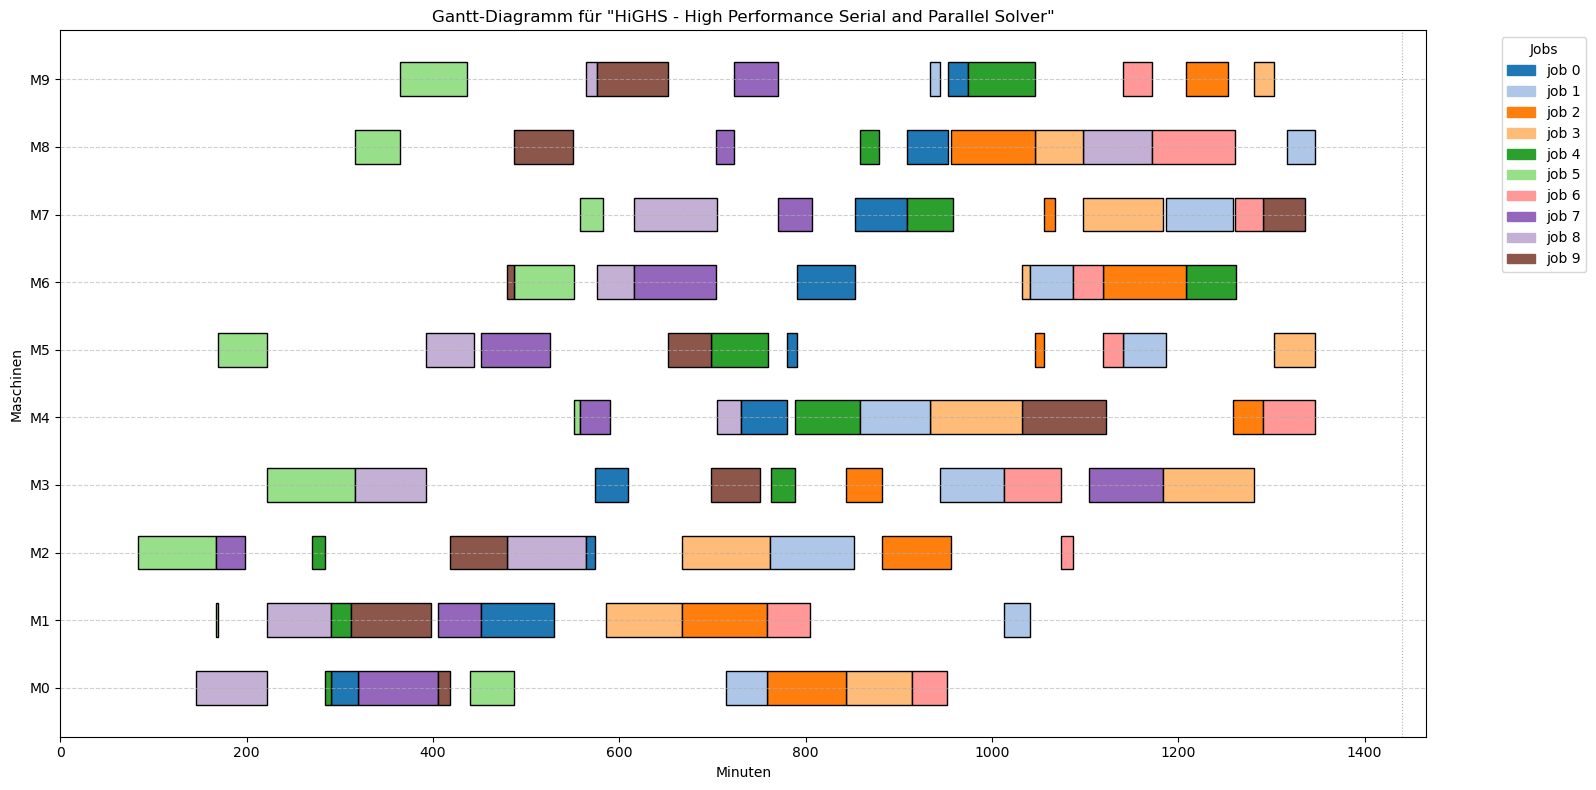

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [27]:
category = "HiGHS - High Performance Serial and Parallel Solver"

show.plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule_highs)

### Export

In [29]:
df_schedule_highs.to_csv("data/02_schedule.csv", index = False)